In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import time
import os


def get_players_and_links(search_link, pages):
    
    players = []
    links = []
        
    for page in range(1, pages):
        link2 = ''.join([search_link,str(page)])
        soup = BeautifulSoup(requests.get(link2).content, 'lxml')

        table = soup.find('table', attrs={'class':'listing'})
        table_rows = table.find_all('tr')

        
        for tr in table_rows[1:]:
            td = tr.find_all('td')
            row = [tr.text for tr in td]
            players.append(row)

        for link in soup.findAll('a', attrs={'href': re.compile("19/players/prices")}):
                            links.append(link.get('href'))
        
        assert len(links)==len(players)
    return players, links

# TODO: add player id 
class PlayerItem:
    def __init__(self, item, link):
        self.name = item[1].split('\n ')[1].strip()
        self.program = item[1].split('\n ')[-1].strip()
        self.ovr = int(item[2])
        self.pos = item[3]
        self.date = None
        self.link = 'https://www.muthead.com' + link
        
    def string(self):
        return f"Player: {self.name}\nProgram: {self.program}\nOVR: {self.ovr}\nDate: {self.date}"
    
    def as_dataframe(self):
        return pd.DataFrame([{'name': self.name, 'program': self.program, 'date': self.date, 
                              'link': self.link, 'ovr': self.ovr, 'pos': self.pos}])
    
# TODO: change date format (from [year, month-1, day] to y/m/d or similar)
def get_release_date(link):
    soup = BeautifulSoup(requests.get(link).content, 'lxml')
    try:
        date = soup.find_all('script', type="text/javascript")[1].string.split('series:')[1].split('Date.UTC')[1].split(')')[0].lstrip('()').split(', ')
        date = [int(x) for x in date]
    except:
        date = soup.find_all('script', type="text/javascript")
        print('Date Error: ----')
    # year, month, day = date
    
    return date


def get_and_save_player_dates(link, n_pages, save_filename, date):
    global pages_map
    global link_map
    
    players, links = get_players_and_links(link, n_pages)
    
    # create list of PlayerItem objects to store data including dates
    player_items = [PlayerItem(item=player, link=link_) for player, link_ in zip(players, links)]#[:5]
    
    #if os.path.isfile(f'{date}_{goal_program}.csv'):
        #df = pd.read_csv(f'{date}_{goal_program}.csv', index_col=0)
        #print('reading previous file... (not doing anything yet)')
        
    # TODO: put full filtering here to limit unneccessary scraping
    
    
    
    # Fetch release dates of players
    for p in player_items:
        time.sleep(2)
        p.date = get_release_date(p.link)
        print(p)
    
    # Convert to dataframe and save as csv
    df = pd.concat([p.as_dataframe() for p in player_items])
    df.reset_index(drop=True, inplace=True)

    df['date_dtype'] = df['date'].apply(lambda x: type(x[0])).astype(str)
    df['dated'] = df['date_dtype'].apply(lambda x: x =="<class 'int'>")*1
    
    df['full'] = 0
    indices = [idx[0] for name, idx in df.groupby(['name'])['ovr'].groups.items()]
    df['index'] = df.index
    df['full'] = df['index'].apply(lambda x: 1 if x in indices else 0)

    df.to_csv(f'{save_filename}_{date}.csv')
    
    return df

In [2]:
# INPUTS

date = 'may17'
# make sure it ends with page=
input_link = 'https://www.muthead.com/19/players?filter-market=3&filter-market-price-min=1&filter-ovr-min=95&page='
n_pages=20
fn = '95plus_player_dates'

df = get_and_save_player_dates(link=input_link, 
                               n_pages=n_pages,
                               save_filename=fn,
                               date=date)

In [3]:
df.head()

,date,link,name,ovr,pos,program,date_dtype,dated,full,index
0,"[2019, 4, 14]",https://www.muthead.com/19/players/prices/6712...,Jamal Adams,99,SS,Position Heroes,<class 'int'>,1,1,0
1,"[2019, 4, 16]",https://www.muthead.com/19/players/prices/6711...,Geno Atkins,99,DT,Position Heroes,<class 'int'>,1,1,1
2,"[2019, 2, 14]",https://www.muthead.com/19/players/prices/6596...,Odell Beckham Jr,99,WR,Movers,<class 'int'>,1,1,2
3,"[2019, 3, 4]",https://www.muthead.com/19/players/prices/6613...,Chuck Bednarik,99,LOLB,NFL Draft,<class 'int'>,1,1,3
4,"[2019, 4, 11]",https://www.muthead.com/19/players/prices/6423...,Bobby Bell,99,LOLB,Ultimate Legends,<class 'int'>,1,1,4


In [4]:
full = df[ df['full']==1]
full['dated'].value_counts()

1    356
Name: dated, dtype: int64

In [12]:
df['date'] = df['date'].apply(lambda x: f'{x[0]}/{x[1]+1}/{x[2]}')

In [15]:
df.drop(['date_dtype', 'dated', 'full', 'index'], axis=1, inplace=True)

In [26]:
df['date'] = pd.to_datetime(df['date'])

In [28]:
df.to_csv('dated_may17_95up.csv')

In [30]:
df['program'].value_counts()

Ultimate Legends        99
Team MVPs               64
NFL Draft               61
Team Builders           34
Ghosts of Madden        28
NFL Combine             27
Team of the Year        26
Legends                 23
NFL Playoffs            20
Color Smash             14
Super Bowl Present      11
Free Agents             10
Super Bowl Past         10
Position Heroes          8
Team of the Week         7
NFL Honors               6
Limited Edition          6
The Gauntlet             5
Primetime Performers     4
Master                   3
Zero Chill               2
Harvest                  2
MUT Loyalty              2
Movers                   2
Blitz                    1
Name: program, dtype: int64

In [37]:
uls = df[ df['program']=='Ultimate Legends']
uls.sort_values('ovr', ascending=False)
top_uls = uls.groupby('name').first()

In [51]:
df2 = pd.concat([df[ df['program']!='Ultimate Legends'], top_uls.reset_index()], axis=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [53]:
df2['program'].value_counts()

Team MVPs               64
NFL Draft               61
Ultimate Legends        51
Team Builders           34
Ghosts of Madden        28
NFL Combine             27
Team of the Year        26
Legends                 23
NFL Playoffs            20
Color Smash             14
Super Bowl Present      11
Free Agents             10
Super Bowl Past         10
Position Heroes          8
Team of the Week         7
NFL Honors               6
Limited Edition          6
The Gauntlet             5
Primetime Performers     4
Master                   3
Zero Chill               2
Harvest                  2
MUT Loyalty              2
Movers                   2
Blitz                    1
Name: program, dtype: int64

In [54]:
df2.reset_index(drop=True, inplace=True)

In [55]:
df2.to_csv('m17_95plus.csv')

In [57]:
df2.head()

,date,link,name,ovr,pos,program
0,2019-05-14,https://www.muthead.com/19/players/prices/6712...,Jamal Adams,99,SS,Position Heroes
1,2019-05-16,https://www.muthead.com/19/players/prices/6711...,Geno Atkins,99,DT,Position Heroes
2,2019-03-14,https://www.muthead.com/19/players/prices/6596...,Odell Beckham Jr,99,WR,Movers
3,2019-04-04,https://www.muthead.com/19/players/prices/6613...,Chuck Bednarik,99,LOLB,NFL Draft
4,2019-04-05,https://www.muthead.com/19/players/prices/6613...,Tom Brady,99,QB,NFL Draft


In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


(736999.0, 737211.0)

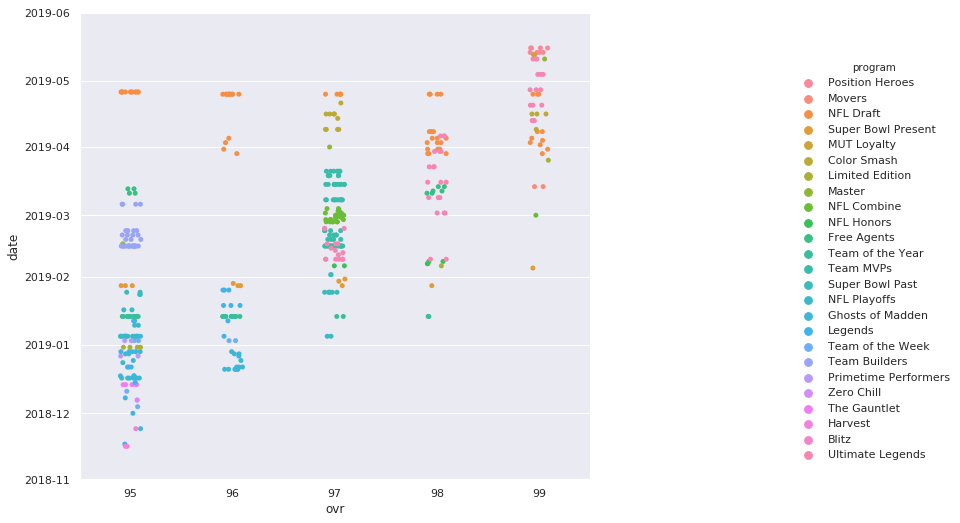

In [93]:
#plt.figure(figsize=(16,10))
g = sns.catplot(x='ovr', y='date', data=df2, hue='program')
g.fig.set_size_inches(16,8)
plt.ylim('2018-11', '2019-06')

(737119.0, 737196.0)

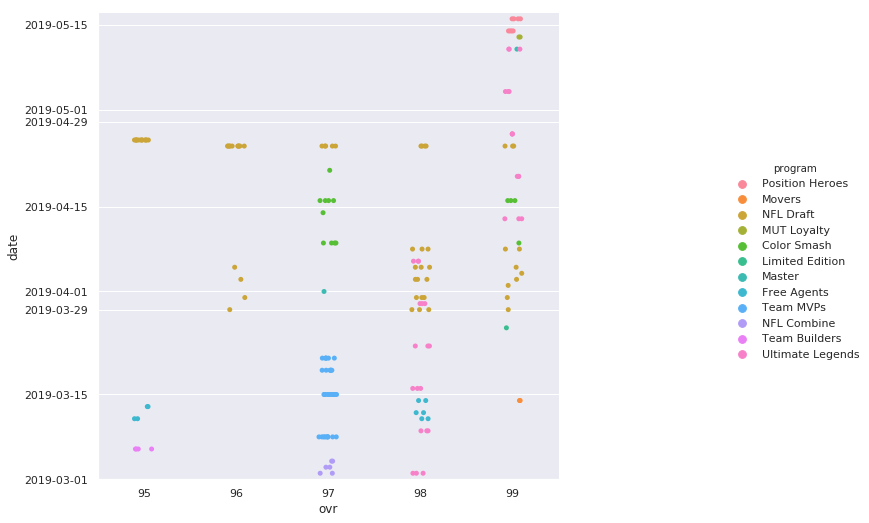

In [91]:
#plt.figure(figsize=(16,10))
df3 = df2[ df2['date'] > '2019-03-01']
g = sns.catplot(x='ovr', y='date', data=df3, hue='program')
g.fig.set_size_inches(15,8)
plt.ylim('2019-03-01', '2019-05-17')

In [74]:
df2.sort_values('date', ascending=False).to_csv('mut_m17.csv')